In [1]:
%%capture
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install pydot --quiet
!pip install transformers==4.17 --quiet
!pip install -U scikit-learn

In [2]:
#Tensorflow libiries
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

#Transformers - BERT from huggingface
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
from transformers import AutoConfig
from tensorflow.keras.callbacks import EarlyStopping

#NLP libiries
import sklearn as sk
from sklearn.metrics import classification_report
import os
import nltk
from nltk.data import find

#data process
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import math
from bs4 import BeautifulSoup
import os
import json


In [3]:
#loading the pre-trained tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [4]:
#load the dataset with error handling
try:
    train_df = pd.read_csv('full_train_data(Revised).csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Print the lines around the problematic row
    with open('full_train_data(Revised).csv', 'r') as f:
        lines = f.readlines()
        for i in range(17622, 17626):
            if i < len(lines):
                print(lines[i])

test_df = pd.read_csv('full_test_data(Revised).csv')

# Adjust pandas display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Auto-detect width of the display




In [5]:
train_df.columns

Index(['title', 'date', 'content_original', 'bias', 'bias_text', 'source'], dtype='object')

In [6]:
#targeted news ogranization to be removed

target_news_org = ['Washington Times', 'CNN (Web News)', 'NPR Online News', 'Politico', 'Vox' ]

In [7]:
train_df = train_df[~train_df['source'].isin(target_news_org)]
test_df = test_df[~test_df['source'].isin(target_news_org)]

In [8]:
train_df['source'].unique()

array(['Christian Science Monitor', 'The Guardian', 'Reason', 'Townhall',
       'Fox Online News', 'Yahoo! The 360', 'TheBlaze.com',
       'National Review', 'Wall Street Journal - Editorial',
       'Business Insider', 'Daily Kos', 'Bloomberg', 'The Week - News',
       'Daily Beast', 'USA TODAY', 'Breitbart News', 'Fox News',
       'Chicago Sun-Times', 'Charles Krauthammer', 'The Atlantic',
       'HotAir', 'MarketWatch', 'New York Times - News', 'Salon',
       'Guest Writer - Left', 'Newsmax', 'FiveThirtyEight',
       'Michelle Malkin', 'Polish Times', 'Reuters', 'Associated Press',
       'Victor Hanson', 'Pew Research Center',
       'New York Times (Online News)', 'City Journal', 'Jonah Goldberg',
       'Guest Writer - Right', 'Fox News Opinion', 'Yahoo! News', 'Slate',
       'Washington Post', 'Mother Jones', 'Newsmax (News)', 'Defense One',
       'Independent Journal Review', 'Peacock Panache',
       'Detroit Free Press', 'CNBC', 'Newsmax - News',
       'Washington Fr

In [ ]:
print(f"basic train_df info: ",train_df.shape)

basic train_df info:  (20114, 6)


In [8]:
print(f"basic train_df info after deleting the top-5 outlier news org: ",train_df.shape)

basic train_df info after deleting the top-5 outlier news org:  (11332, 6)


In [ ]:
print(f"basic test_df info: ",test_df.shape)

basic test_df info:  (5029, 6)


In [9]:
print(f"basic test_df info after deleting the top-5 outlier news org: ",test_df.shape)

basic test_df info after deleting the top-5 outlier news org:  (2805, 6)


In [10]:
# extract the train and test text from both dataframes
train_text = train_df['content_original']
train_text_labels = train_df['bias']

validate_text = test_df['content_original'][0:1500]
validate_text_labels = test_df['bias'][0:1500]

test_text = test_df['content_original'][1500:]
test_text_labels = test_df['bias'][1500:]


print(f"size of training dataset: ",len(train_text))
print()
print(f"size of valid dataset: ",len(validate_text))
print()
print(f"size of testing dataset: ",len(test_text))
print()
print(f"Left with Label 0 ")
print(f"Center with Label 1 ")
print(f"Right with Label 2 ")

size of training dataset:  11332

size of valid dataset:  1500

size of testing dataset:  1305

Left with Label 0 
Center with Label 1 
Right with Label 2 


In [11]:
MAX_SEQUENCE_LENGTH = 512

In [12]:
# tokenize the dataset, truncate at `max_length`,

#tokenizing the train text
x_train = bert_tokenizer(train_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_text_labels

#tokenizing the validate text
x_validate = bert_tokenizer(validate_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_validate = validate_text_labels


#tokenizing the test text
x_test = bert_tokenizer(test_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = test_text_labels

In [13]:
#BERT base uncased model configurations
config = AutoConfig.from_pretrained('bert-base-uncased')

config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#BERT Uncase Model Fine-Tuning

In [14]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     num_classes = 3,
                                     hidden_size = 768,
                                     dropout=0.3,
                                     attention_probs_dropout_prob = 0.2,
                                     hidden_dropout_prob=0.25,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(cls_token)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden_1)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [15]:
#let's get a fresh instance of the bert_model -- good practice
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [17]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                      

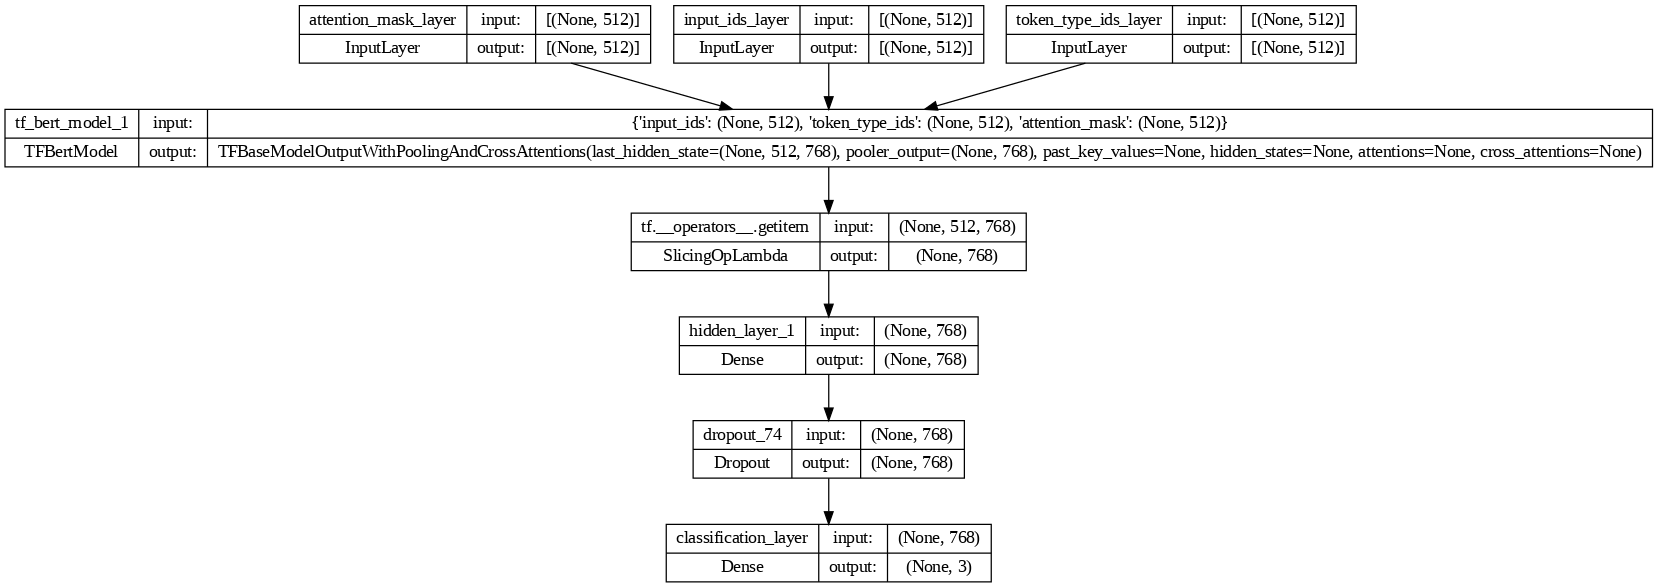

In [ ]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping callback to avoid overfitting issue
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    mode='max',
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [17]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_validate.input_ids, x_validate.token_type_ids, x_validate.attention_mask], y_validate),
    batch_size=16,
    epochs=4,
    callbacks=[early_stopping]
)

Epoch 1/4


709/709 [==============================] - 885s 1s/step - loss: 0.6270 - accuracy: 0.7319 - val_loss: 0.4673 - val_accuracy: 0.8227
Epoch 2/4
709/709 [==============================] - 842s 1s/step - loss: 0.3416 - accuracy: 0.8759 - val_loss: 0.3247 - val_accuracy: 0.8767
Epoch 3/4
709/709 [==============================] - 842s 1s/step - loss: 0.2445 - accuracy: 0.9139 - val_loss: 0.3542 - val_accuracy: 0.8700
Epoch 4/4
709/709 [==============================] - 843s 1s/step - loss: 0.1615 - accuracy: 0.9448 - val_loss: 0.3345 - val_accuracy: 0.8933


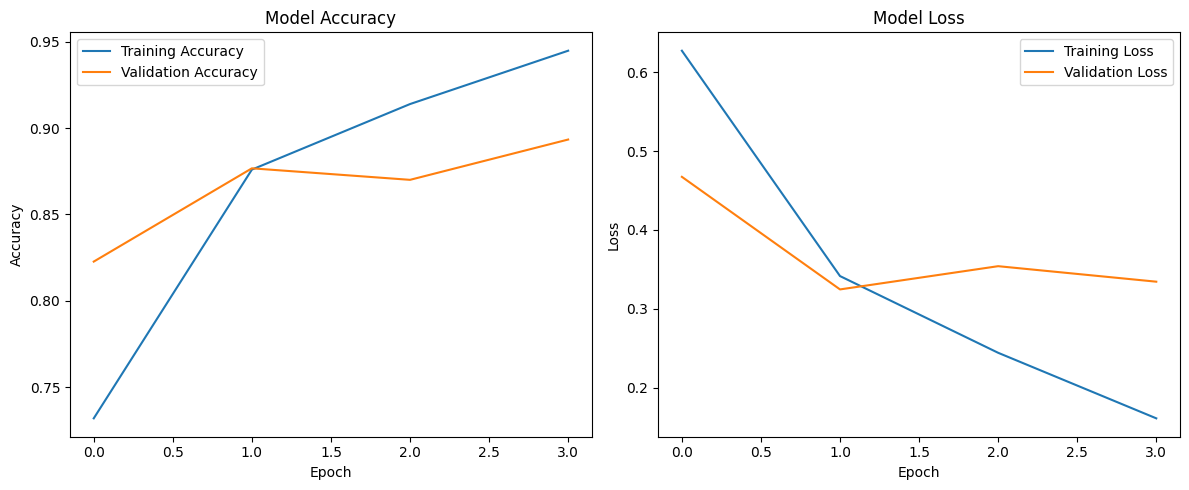

In [18]:
history = bert_classification_model_history.history

# Plotting accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Fine-Tuned BERT model overall prediction score
score = bert_classification_model.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                                                  y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

95/95 [==============================] - 25s 265ms/step - loss: 0.2783 - accuracy: 0.9052
Test loss: 0.2782779335975647
Test accuracy: 0.9052492380142212


In [19]:
predictions_model= bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
predictions_model = tf.argmax(predictions_model, axis=-1)
predictions_model

41/41 [==============================] - 33s 732ms/step


<tf.Tensor: shape=(1305,), dtype=int64, numpy=array([2, 0, 2, ..., 2, 2, 2])>

In [20]:
print(classification_report(y_test, predictions_model.numpy(),
                            target_names=['Left ','Center','Right']))

              precision    recall  f1-score   support

       Left        0.92      0.85      0.88       387
      Center       0.92      0.85      0.89       356
       Right       0.87      0.95      0.90       562

    accuracy                           0.89      1305
   macro avg       0.90      0.89      0.89      1305
weighted avg       0.90      0.89      0.89      1305



In [21]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

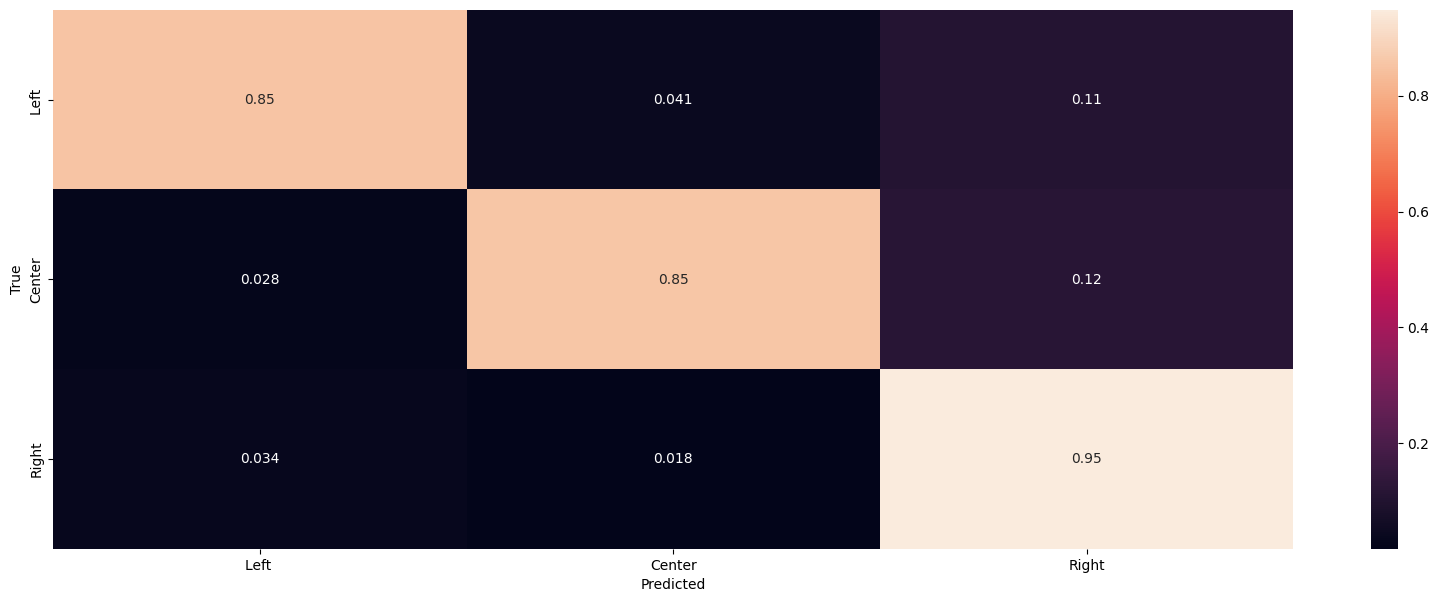

In [22]:
target_names=['Left ','Center','Right']
plot_confusion_matrix(y_test, predictions_model.numpy(), target_names)

In [23]:
bert_wrong_guesses = np.where(y_test != predictions_model.numpy())

In [24]:
print(f'Number of Wrong Guesses: ',len(bert_wrong_guesses[0]))

Number of Wrong Guesses:  138


In [25]:
#sampling 20 of the wrong precditions
wrong_guesses = [i for i in np.squeeze(bert_wrong_guesses[0])]
decoded_wrong_guesses_text=[]

for i in wrong_guesses[:]:
  decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  # print("Input text:")
  # print(decoded_text)
  decoded_wrong_guesses_text.append(decoded_text)
  # print("True label:")
  # print(y_test.iloc[i])
  # print("Predicted label:")
  # print(predictions_model.numpy()[i])

  # print("-" * 50)



In [26]:
len(decoded_wrong_guesses_text)

138

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
# Define the path to save the model in Google Drive

save_path = '/content/drive/My Drive/'  # for TensorFlow/Keras

# Save the model

bert_classification_model.save(save_path)  # TensorFlow/Keras

In [ ]:
# Load the model
model = tf.keras.models.load_model('path_to_your_model.h5')

In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('my_saved_model.h5')

# Summary of the model
model.summary()

# Make predictions
input_data = ...  # Replace with your input data
predictions = model.predict(input_data)

# Evaluate the model
test_data = ...  # Replace with your test data
test_labels = ...  # Replace with your test labels
loss, accuracy = model.evaluate(test_data, test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')

In [27]:
sources_analysis = test_df.loc[wrong_guesses]

KeyError: '[5, 8, 48, 99, 109, 147, 151, 177, 182, 196, 198, 242, 250, 269, 318, 319, 361, 370, 372, 405, 409, 416, 434, 458, 474, 486, 499, 502, 505, 506, 513, 520, 524, 544, 551, 580, 605, 619, 675, 690, 694, 703, 724, 797, 803, 834, 877, 878, 893, 932, 972, 1128, 1154, 1170, 1191, 1198, 1246, 1261, 1270, 1275] not in index'

In [30]:
sources_analysis['source']
# Count the occurrences of each source
source_counts = sources_analysis['source'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
source_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Wrong Guess''Sources')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'sources_analysis' is not defined

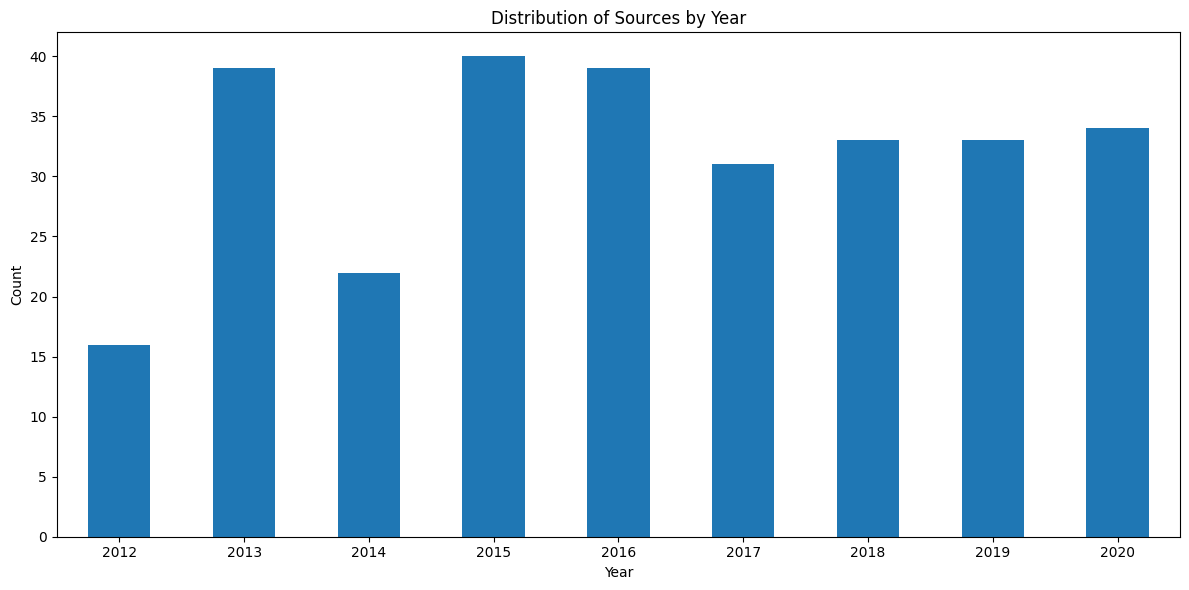

In [ ]:
# Convert 'date' to datetime if it's not already
sources_analysis['date'] = pd.to_datetime(sources_analysis['date'])

# Extract year from the date
sources_analysis['year'] = sources_analysis['date'].dt.year

# Count occurrences of each year
year_counts = sources_analysis['year'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Sources by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)  # No rotation for years
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
for i in wrong_guesses[:50]:
  decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  print("Input text:")
  print(decoded_text)
  print("True label:")
  print(y_test.iloc[i])
  print("Predicted label:")
  print(predictions_model.numpy()[i])

  print("-" * 50)


Input text:
this 2012 presidential race one kind. history crown year debates. and three presidential debate shook race put republican mitt romney back game. the history making element 2012 debate year became interactive social medium event attracting massive audiences. rivaled super bowl wrestlemania audience size lust combat american first time communal experience scoring debate real time. on twitter blog debate scored minute minute grandma, kid everyone else living room. star hollywood medium personalities, politician joined fun folk home. whole nation competed best oneliners, perfect putdown come back debate taking place. trying appear presidential, cagematch mentality sober, thoughtful, reserved approach work social medium world want zinger mock opponent. president obama lost first debate failing satisfy big crowd refusing draw blood. mitt romney similarly lost last debate failing take fight president foreign affairs. the second debate, candidate looking verge fistfight, interrupti

In [ ]:
sources_analysis.to_csv('bert_fine_tuning_wrong guess(7.24.24).csv', index=False)